In [1]:
BUCKET_NAME = 'realtimeattendanceproject'
KEY_FILE = '/Users/swg/Desktop/realtimeattendanceproject@noble-cocoa-217110.iam.gserviceaccount.com.json'
SELECTOR_REGEX = r'^train2/(\w+)/(\d+.png)$'
SEED = 20
DESIRED_SIZE = (100, 100)

In [2]:
from google.cloud import storage

import re
from functools import reduce

from pprint import pprint
import time

import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC

from matplotlib import pyplot as plt
%matplotlib inline

import pickle

In [3]:
client = storage.Client.from_service_account_json(KEY_FILE)
bucket = client.get_bucket(BUCKET_NAME)

In [4]:
def seive_train(blob):
    return re.match(SELECTOR_REGEX, blob.name) is not None

def get_md(blob): 
    re_obj = re.match(SELECTOR_REGEX, blob.name)
    return {
        'class_label': re_obj.group(1),
        'path': re_obj.group(0)
    }

img_res = filter(seive_train, bucket.list_blobs())

img_md = list(map(get_md, img_res))
pprint(img_md)

def reduction_step(prev, nex):
    if not nex['class_label'] in prev:
        prev.append(nex['class_label'])
    return prev

class_labels = reduce(reduction_step, img_md, [])
print(class_labels)

[{'class_label': 'akanksha', 'path': 'train2/akanksha/0.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/1.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/10.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/11.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/12.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/13.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/14.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/15.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/16.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/17.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/18.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/19.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/2.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/20.png'},
 {'class_label': 'akanksha', 'path': 'train2/akanksha/21.png'},
 {'class_label': 'akanksha', 'path': 'train

In [5]:
def translate_class_labels(img_md):
    img_md['class_label'] = class_labels.index(img_md['class_label'])
    return img_md
img_md = list(map(translate_class_labels, img_md))

In [6]:
t0 = time.time()
ctr = 0.0 # OPTIONAL PART: PROGRESS BAR
def read_image(md):
    blob_bytes = bucket.get_blob(md['path']).download_as_string()
    blob_array = np.asarray(bytearray(blob_bytes), dtype = 'uint8')
    image = cv2.imdecode(blob_array, 0) # 0 for grayscale
    image_resized = cv2.resize(image, DESIRED_SIZE).flatten()
    
    global ctr # OPTIONAL PART: PROGRESS BAR
    ctr += 1 # OPTIONAL PART: PROGRESS BAR
    print('progress: %f' % (ctr / len(img_md)), end = '\r') # OPTIONAL PART: PROGRESS BAR
    
    return (image_resized, md['class_label'])

X, y = [
    list(t) for t in zip(
        *[read_image(md) for md in img_md]
    )
]
X, y = np.array(X, dtype = 'uint8'), np.array(y, dtype = 'uint8') 
print('Total: %0.3f seconds' % (time.time() - t0))

Total: 614.619 seconds


In [7]:
n_samples, h, w = X.shape[0], DESIRED_SIZE[0], DESIRED_SIZE[1]
n_features = X.shape[1]
n_classes = len(class_labels)
print("Dataset:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Dataset:
n_samples: 1207
n_features: 10000
n_classes: 22


In [8]:
TEST_SIZE = 0.2
# split into training testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [9]:
# this is the maximum possible PC
# may not yield good for large data set, LOOKUP!
N_PCA_COMPONENTS = int(min(n_samples, n_features) * (1 - TEST_SIZE)) # lookup how this is determined in svd_solver
N_PCA_COMPONENTS = 150

# DIMENSIONALITY REDUCTION USING PCA
print('Extracting top', N_PCA_COMPONENTS, 'eigen faces')
pca = PCA(n_components=N_PCA_COMPONENTS, svd_solver='randomized', whiten=True).fit(X_train)

Extracting top 150 eigen faces


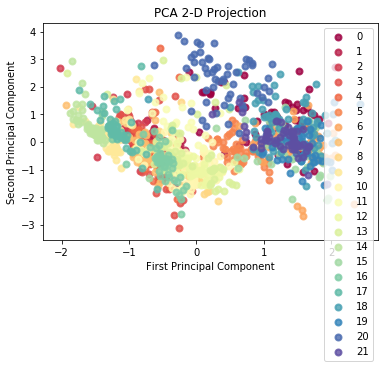

In [10]:
import scikitplot as skplt
skplt.decomposition.plot_pca_2d_projection(pca, X, y)

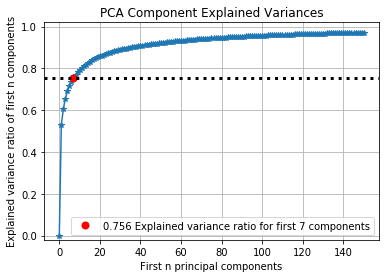

In [11]:
skplt.decomposition.plot_pca_component_variance(pca)

showing top 36 eigen faces


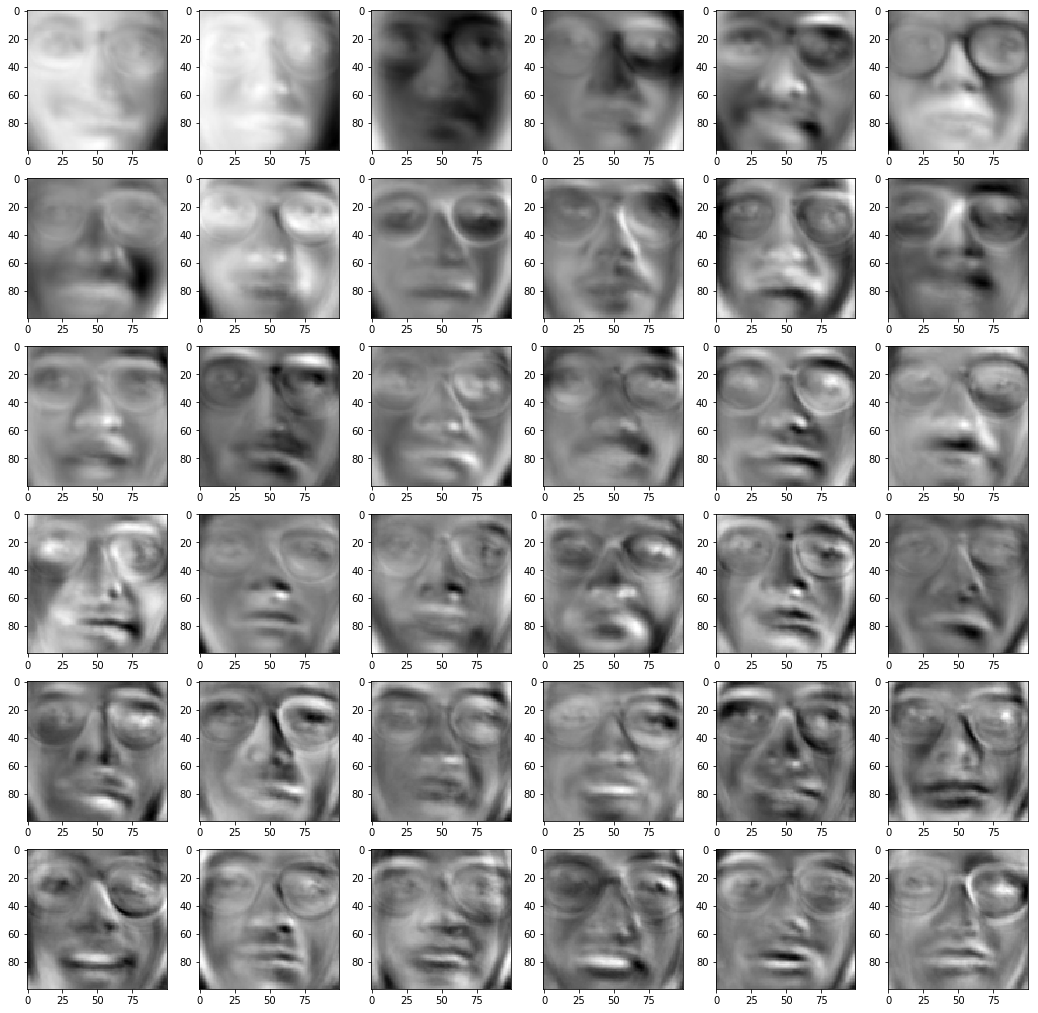

In [14]:
GRID = 6
eigenfaces = pca.components_.reshape((N_PCA_COMPONENTS, h, w))
print('showing top', GRID ** 2, 'eigen faces')
fig, axs = plt.subplots(GRID, GRID)
fig.set_figheight(18)
fig.set_figwidth(18)

ctr = 0
for eigenface in eigenfaces[0:GRID ** 2]:
    r_index = ctr // GRID
    c_index = ctr % GRID
    axs[r_index, c_index].imshow(eigenface, cmap = 'gray')
    ctr += 1
plt.show()

In [15]:
print('projecting the input data on the eigenfaces orthonormal basis')
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('done')

projecting the input data on the eigenfaces orthonormal basis
done


In [16]:
# TRAIN A CLASSIFICATION MODEL USING GRIDSEARCHCV
print("fitting to the training set")
# param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5]}

# clf = GridSearchCV(
#     LinearSVC(), param_grid, cv = 5
# )

# clf = clf.fit(X_train_pca, y_train)

# # Lookup this part
# print("Best estimator found by grid search:")
# print(clf.best_estimator_)

clf = LinearSVC(C=1e3, max_iter=10000)
clf.fit(X_train_pca, y_train)
print('Estimator is: ', clf)

fitting to the training set
Estimator is:  LinearSVC(C=1000.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


prediction time! on test dataset
              precision    recall  f1-score   support

    akanksha       0.88      1.00      0.93         7
       anand       1.00      0.85      0.92        13
       ankit       0.92      0.86      0.89        14
   anshudeep       0.88      1.00      0.93         7
      aryanl       0.86      1.00      0.92         6
         dev       0.92      1.00      0.96        12
      ishaan       1.00      1.00      1.00        15
      jayesh       1.00      1.00      1.00         9
       krish       1.00      1.00      1.00         9
     kshitij       1.00      1.00      1.00        13
       mehak       0.91      1.00      0.95        10
       mudit       1.00      1.00      1.00         6
        neha       1.00      0.78      0.88         9
       nisha       0.92      0.75      0.83        16
        puru       1.00      1.00      1.00        11
      rahuls       1.00      0.91      0.95        11
      rishab       1.00      0.92      0.96     

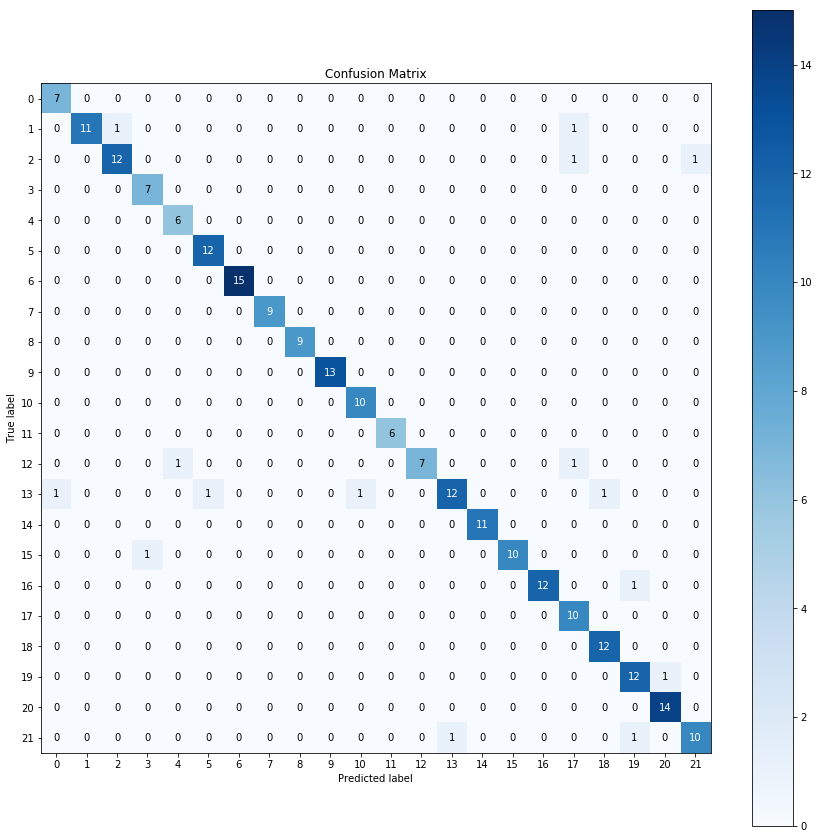

In [20]:
from scikitplot.metrics import plot_confusion_matrix
print('prediction time! on test dataset')
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=class_labels))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
plot_confusion_matrix(y_test, y_pred, labels=range(n_classes), figsize=(15, 15))

In [21]:
print('accuracy score on test data set')
clf.score(X_test_pca, y_test)

accuracy score on test data set


0.9380165289256198

In [19]:
def save_as_pickle(file_name, obj):
    pickle_bytes = pickle.dumps(obj)
    blob = bucket.blob(file_name)
    blob.upload_from_string(pickle_bytes, 'application/octet-stream')
    print('saved to gs://%s/%s' % (BUCKET_NAME, file_name))

save_as_pickle('pca.pickle', pca)
save_as_pickle('class_labels.pickle', class_labels)
save_as_pickle('model.pickle', clf)

saved to gs://realtimeattendanceproject/pca.pickle
saved to gs://realtimeattendanceproject/class_labels.pickle
saved to gs://realtimeattendanceproject/model.pickle
